In [1]:
import triton
print(triton.__version__)

3.2.0


In [2]:
import torch
print(torch.__version__)

2.6.0+cu124


Forward test passed: 135.741653 vs 135.741638
Backward test passed.


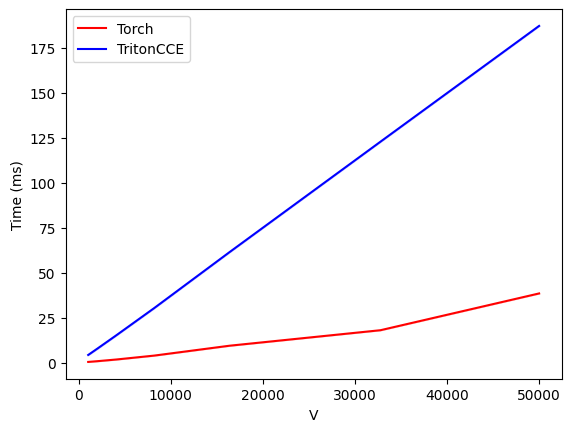

CCE Benchmark:
         V      Torch   TritonCCE
0   1024.0   0.525076    4.386370
1   2048.0   0.947567    8.007233
2   4096.0   1.877020   15.369844
3   8192.0   4.036475   30.399828
4  16384.0   9.524503   61.495296
5  32768.0  18.121931  122.750977
6  50000.0  38.534142  187.009018
Torch       time: 14.12 ms   peak mem: 2321.3 MB
TritonCCE   time: 31.66 ms   peak mem: 273.5 MB
Torch BWD   time: 40.87 ms   peak mem: 3345.3 MB
TritonCCE BWD  time: 57.47 ms   peak mem: 273.9 MB


In [6]:
import torch
import triton
import triton.language as tl
import triton.testing

@triton.jit
def _cce_fwd_parallel_kernel(
    E_ptr, C_ptr, x_ptr, lse_ptr, logits_corr_ptr, Locks,
    stride_E_N, stride_E_D, stride_C_V, stride_C_D,
    stride_lse, stride_logits_corr, stride_locks,
    N, V, D: tl.constexpr,
    BLOCK_N: tl.constexpr, BLOCK_V: tl.constexpr, NUM_LOCKS: tl.constexpr
):
    pid = tl.program_id(0)
    num_pid_n = tl.cdiv(N, BLOCK_N)
    pid_n = pid % num_pid_n # do in this order for less contention.
    pid_v = pid // num_pid_n

    # compute row and vocab blocks
    row_ids = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    mask_n = row_ids < N
    col_ids = pid_v * BLOCK_V + tl.arange(0, BLOCK_V)
    mask_v = col_ids < V

    # accumulate dot products over D dimension
    accum = tl.zeros((BLOCK_N, BLOCK_V), dtype=tl.float32)
    # Explicit D-loop for dot product
    # Alternative implementation processing 4 elements per iteration:
    # Compute dot product over D dimension with reduced memory pressure
    # Faster, but much more memory; not used.
    # for d in range(0, D, 4):
    #     # Load 4 elements at once for E and C
    #     e_d = tl.load(E_ptr + row_ids * stride_E_N + d * stride_E_D, mask=mask_n, other=0.0)
    #     c_d = tl.load(C_ptr + col_ids * stride_C_V + d * stride_C_D, mask=mask_v, other=0.0)
    #     
    #     # Handle remaining elements if D is not divisible by 4
    #     if d + 1 < D:
    #         e_d1 = tl.load(E_ptr + row_ids * stride_E_N + (d + 1) * stride_E_D, mask=mask_n, other=0.0)
    #         c_d1 = tl.load(C_ptr + col_ids * stride_C_V + (d + 1) * stride_C_D, mask=mask_v, other=0.0)
    #         accum += e_d1[:, None] * c_d1[None, :]
    #         
    #     if d + 2 < D:
    #         e_d2 = tl.load(E_ptr + row_ids * stride_E_N + (d + 2) * stride_E_D, mask=mask_n, other=0.0)
    #         c_d2 = tl.load(C_ptr + col_ids * stride_C_V + (d + 2) * stride_C_D, mask=mask_v, other=0.0)
    #         accum += e_d2[:, None] * c_d2[None, :]
    #         
    #     if d + 3 < D:
    #         e_d3 = tl.load(E_ptr + row_ids * stride_E_N + (d + 3) * stride_E_D, mask=mask_n, other=0.0)
    #         c_d3 = tl.load(C_ptr + col_ids * stride_C_V + (d + 3) * stride_C_D, mask=mask_v, other=0.0)
    #         accum += e_d3[:, None] * c_d3[None, :]
    #         
    #     # Add the first element's contribution
    #     accum += e_d[:, None] * c_d[None, :]
    for d in range(D):
        # load E[:,d] and C[:,d]
        e_d = tl.load(E_ptr + row_ids * stride_E_N + d * stride_E_D, mask=mask_n, other=0.0)
        c_d = tl.load(C_ptr + col_ids * stride_C_V + d * stride_C_D, mask=mask_v, other=0.0)
        accum += e_d[:, None] * c_d[None, :]

    logits = tl.where(mask_v[None, :], accum, -float('inf'))
    block_max = tl.max(logits, axis=1)
    logits_stable = logits - block_max[:, None]
    sumexp = tl.sum(tl.exp(logits_stable), axis=1)
    block_lse = block_max + tl.log(sumexp)

    # correct logit extraction
    tgt = tl.load(x_ptr + row_ids, mask=mask_n, other=0)
    in_block = mask_n & (tgt >= pid_v * BLOCK_V) & (tgt < pid_v * BLOCK_V + BLOCK_V)
    corr_mask = col_ids[None, :] == tgt[:, None]
    corr_vals = tl.sum(tl.where(corr_mask, logits, 0.0), axis=1)

    # atomic accumulation of LSE using locks
    for i in range(BLOCK_N):
        r = pid_n * BLOCK_N + i
        if r < N:
            lock_id = (r * NUM_LOCKS) // N
            lock_ptr = Locks + lock_id * stride_locks
            while tl.atomic_cas(lock_ptr, 0, 1) == 1:
                pass
            old = tl.load(lse_ptr + r * stride_lse)
            mask_i = tl.arange(0, BLOCK_N) == i
            block_lse_i = tl.sum(tl.where(mask_i, block_lse, 0.0))
            new_max = old if old > block_lse_i else block_lse_i
            new_val = new_max + tl.log(tl.exp(old - new_max) + tl.exp(block_lse_i - new_max))
            tl.store(lse_ptr + r * stride_lse, new_val)
            tl.atomic_xchg(lock_ptr, 0)

    # store correct logit
    tl.store(logits_corr_ptr + row_ids * stride_logits_corr, corr_vals, mask=in_block)

@triton.jit
def _cce_bwd_kernel(
    E_ptr, C_ptr, x_ptr, lse_ptr, dloss_ptr,
    dE_ptr, dC_ptr,
    stride_E_N, stride_E_D,
    stride_C_V, stride_C_D,
    stride_dE_N, stride_dE_D,
    stride_dC_V, stride_dC_D,
    N, V, D: tl.constexpr,
    BLOCK_V: tl.constexpr
):
    row = tl.program_id(0)
    block_id = tl.program_id(1)
    start_v = block_id * BLOCK_V
    offs_v = start_v + tl.arange(0, BLOCK_V)
    mask_v = offs_v < V

    # load embedding e_i
    e = tl.load(E_ptr + row * stride_E_N + tl.arange(0, D) * stride_E_D)
    # load C_block
    C_block = tl.load(
        C_ptr
        + offs_v[:, None] * stride_C_V
        + tl.arange(0, D)[None, :] * stride_C_D,
        mask=mask_v[:, None]
    )
    # load lse
    lse = tl.load(lse_ptr + row)

    # compute logits_block
    logits = tl.sum(C_block * e[None, :], axis=1)
    # compute softmax
    p = tl.exp(logits - lse)
    # gradient w.r.t. logits: p_j - 1 for j == target
    tgt = tl.load(x_ptr + row)
    mask_target = offs_v == tgt
    grad_logits = p - mask_target.to(tl.float32)

    # load incoming gradient for this row (scalar)
    grad_loss = tl.load(dloss_ptr + row)
    coeff = grad_loss / N
    grad_logits = grad_logits * coeff

    # update dE: sum_v grad_logits[v] * C_block[v]
    grad_e = tl.sum(grad_logits[:, None] * C_block, axis=0)
    # atomic add to dE[row]
    ptr_e = dE_ptr + row * stride_dE_N + tl.arange(0, D) * stride_dE_D
    tl.atomic_add(ptr_e, grad_e)

    # update dC_block: for each v in block, add grad_logits[v] * e
    grad_c = grad_logits[:, None] * e[None, :]
    ptr_c = (
        dC_ptr
        + offs_v[:, None] * stride_dC_V
        + tl.arange(0, D)[None, :] * stride_dC_D
    )
    tl.atomic_add(ptr_c, grad_c)

class TritonCCE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, E, C, x, block_size=128, block_n=16, num_locks=128):
        # E: [N,D], C: [V,D], x: [N]
        assert E.dim() == 2 and C.dim() == 2
        N, D = E.shape
        V, D_ = C.shape
        assert D == D_
        # allocate intermediates
        lse = torch.full((N,), -float('inf'), dtype=E.dtype, device=E.device)
        logits_corr = torch.zeros((N,), dtype=E.dtype, device=E.device)
        # launch new parallel forward kernel
        locks = torch.zeros((num_locks,), dtype=torch.uint32, device=E.device)
        grid = (triton.cdiv(N, block_n) * triton.cdiv(V, block_size),)
        _cce_fwd_parallel_kernel[grid](
            E, C, x, lse, logits_corr, locks,
            E.stride(0), E.stride(1),
            C.stride(0), C.stride(1),
            lse.stride(0), logits_corr.stride(0), locks.stride(0),
            N, V, D,
            BLOCK_N=block_n, BLOCK_V=block_size, NUM_LOCKS=num_locks
        )
        # compute final loss
        loss = (lse - logits_corr).mean()
        ctx.save_for_backward(E, C, x, lse)
        ctx.block_size = block_size
        return loss

    @staticmethod
    def backward(ctx, grad_loss):
        E, C, x, lse = ctx.saved_tensors
        N, D = E.shape
        V, _ = C.shape
        # alloc grads
        dE = torch.zeros_like(E)
        dC = torch.zeros_like(C)
        # prepare a vector of per‐row grad_loss entries
        grad_vec = grad_loss.expand(N).contiguous()
        # launch backward kernel
        grid = (N, triton.cdiv(V, ctx.block_size))
        _cce_bwd_kernel[grid](
            E, C, x, lse, grad_vec,
            dE, dC,
            E.stride(0), E.stride(1),
            C.stride(0), C.stride(1),
            dE.stride(0), dE.stride(1),
            dC.stride(0), dC.stride(1),
            N, V, D, BLOCK_V=ctx.block_size
        )
        return dE, dC, None, None

# Convenience module
def triton_cut_cross_entropy(E, C, x, block_size=64):
    return TritonCCE.apply(E, C, x, block_size)

# Numerical correctness tests for CCE kernel
def test_forward():
    # setup parameters
    N = 2048
    V = 50000
    D = 1024
    block_size = 256
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    E = torch.randn(N, D, device=device, dtype=torch.float32, requires_grad=True)
    C = torch.randn(V, D, device=device, dtype=torch.float32, requires_grad=True)
    x = torch.randint(0, V, (N,), device=device, dtype=torch.long)
    # reference loss
    logits = E @ C.t()
    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    ref_loss = loss_fn(logits, x)
    # triton loss
    tri_loss = triton_cut_cross_entropy(E, C, x, block_size)
    assert torch.isclose(ref_loss, tri_loss, atol=1e-5), f"Forward test failed: ref={ref_loss.item()}, tri={tri_loss.item()}"
    print(f"Forward test passed: {ref_loss.item():.6f} vs {tri_loss.item():.6f}")

def test_backward():
    # setup parameters
    N = 2048
    V = 50000
    D = 1024
    block_size = 256
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    E = torch.randn(N, D, device=device, dtype=torch.float32, requires_grad=True)
    C = torch.randn(V, D, device=device, dtype=torch.float32, requires_grad=True)
    x = torch.randint(0, V, (N,), device=device, dtype=torch.long)
    # reference backward
    logits = E @ C.t()
    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    ref_loss = loss_fn(logits, x)
    ref_loss.backward()
    ref_dE = E.grad.clone()
    ref_dC = C.grad.clone()
    # triton backward
    E.grad = None
    C.grad = None
    tri_loss = triton_cut_cross_entropy(E, C, x, block_size)
    tri_loss.backward()
    tri_dE = E.grad.clone()
    tri_dC = C.grad.clone()
    # compare gradients
    assert torch.allclose(ref_dE, tri_dE, atol=1e-5), f"Backward test dE failed: max diff={(ref_dE - tri_dE).abs().max().item()}"
    assert torch.allclose(ref_dC, tri_dC, atol=1e-5), f"Backward test dC failed: max diff={(ref_dC - tri_dC).abs().max().item()}"
    print("Backward test passed.")

# Simple benchmark against vanilla torch
configs = [
    triton.testing.Benchmark(
        x_names=["V"],
        x_vals=[1024, 2048, 4096, 8192, 16384, 32768, 50000],
        line_arg="provider",
        line_vals=["Torch", "TritonCCE"],
        line_names=["Torch", "TritonCCE"],
        styles=[("red", "-"), ("blue", "-")],
        ylabel="Time (ms)",
        plot_name="CCE Benchmark",
        args={"N": 2048, "D": 1024, "block_size": 1024},
    )
]
@triton.testing.perf_report(configs)
def benchmark(V, provider, N, D, block_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    E = torch.randn(N, D, device=device, dtype=torch.float32)
    C = torch.randn(V, D, device=device, dtype=torch.float32)
    x = torch.randint(0, V, (N,), device=device, dtype=torch.long)
    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    if provider == "Torch":
        result = triton.testing.do_bench(lambda: loss_fn(E @ C.t(), x))
    else:
        result = triton.testing.do_bench(lambda: triton_cut_cross_entropy(E, C, x, block_size))
    if isinstance(result, tuple):
        ms, min_ms, max_ms = result
    else:
        ms = min_ms = max_ms = result
    return ms, min_ms, max_ms

def measure_time_and_memory(fn, device):
    # reset PyTorch's peak-mem counter
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.synchronize(device)
    # measure time
    ms = triton.testing.do_bench(fn)
    torch.cuda.synchronize(device)
    # read back the high-water mark (in bytes)
    peak = torch.cuda.max_memory_allocated(device)
    return ms, peak

if __name__ == "__main__":
    test_forward()
    test_backward()
    benchmark.run(show_plots=True, print_data=True)
    N = 16384
    D = 4
    V = 16384
    block_size = 128
    # example usage
    device = torch.device("cuda")
    E = torch.randn(N, D, device=device, requires_grad=True)
    C = torch.randn(V, D, device=device, requires_grad=True)
    x = torch.randint(0, V, (N,), device=device)

    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    def run_torch():
        return loss_fn(E @ C.t(), x)

    def run_triton():
        return triton_cut_cross_entropy(E, C, x, block_size)

    for provider, fn in [("Torch", run_torch), ("TritonCCE", run_triton)]:
        ms, peak_bytes = measure_time_and_memory(fn, device)
        print(f"{provider:10s}  time: {ms:.2f} ms   peak mem: {peak_bytes/1024**2:.1f} MB")

    # benchmark backward pass
    def run_torch_backward():
        E.grad = None
        C.grad = None
        loss = loss_fn(E @ C.t(), x)
        loss.backward()

    def run_triton_backward():
        E.grad = None
        C.grad = None
        loss = triton_cut_cross_entropy(E, C, x, block_size)
        loss.backward()

    for provider, fn in [("Torch BWD", run_torch_backward), ("TritonCCE BWD", run_triton_backward)]:
        ms, peak_bytes = measure_time_and_memory(fn, device)
        print(f"{provider:10s}  time: {ms:.2f} ms   peak mem: {peak_bytes/1024**2:.1f} MB") 

In [1]:
print("um chat its slow but holy memory gains")

um chat its slow but holy memory gains
